# **Quantum-Inspired Portfolio Optimization using CVaR and VQE**
***James Imanuel Genese***

This project explores the use of quantum-inspired algorithms to solve a classic financial challenge of selecting an investment portfolio that balances profit and risk. By combining the Variational Quantum Eigensolver (VQE), a quantum algorithm, with Conditional Value-at-Risk (CVaR), we simulate how quantum techniques might offer better strategies for financial decision-making. This notebook demonstrates a hybrid workflow that uses synthetic data, quantum circuit simulation via Cirq, and post-selection rules for practical constraints like turnover and sector diversity.

## **Background & Key Concepts**

### Portfolio Optimization
In finance, choosing the best combination of assets to invest in is known as portfolio optimization. Investors aim to maximize returns while minimizing risk.

### Conditional Value-at-Risk (CVaR)
CVaR is a measure that looks at the expected loss in the worst-case scenarios. Think of it as the average of your 'bad luck' days.

### Quantum Computing & VQE
The Variational Quantum Eigensolver (VQE) is like tuning a guitar string: it adjusts quantum circuit parameters until it finds the 'lowest energy' or in our case, the lowest risk portfolio. We model the problem as a QUBO (Quadratic Unconstrained Binary Optimization) and simulate the quantum circuit using Cirq.

This hybrid approach blends physics, finance, and data science to explore the future of smart investment tools.

### **Install and Import Packages**

In [34]:
# === Install Cirq (Quantum Library) ===
!pip install cirq -q

# === General Purpose Libraries ===
import datetime
from pathlib import Path

# === Numerical and Data Processing ===
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# === Visualization ===
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.ticker as mtick

# === Quantum Computing ===
import cirq
from cirq.contrib.svg import SVGCircuit

# === Symbolic Mathematics ===
import sympy

# === Progress Bar ===
from tqdm.auto import tqdm

# === Jupyter Utilities ===
from IPython.display import SVG, display

# === Mount Google Drive (Colab Only) ===
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Data Simulation & Preprocessing**

To simulate a realistic financial environment, we generated **synthetic daily return data** for a set of 12 assets over 30 trading days. These assets were grouped into different sectors to reflect industry-based allocation. Synthetic data is commonly used in prototyping models when real market data is unavailable or overly complex.

For each asset, we computed:

- **Daily returns**, representing potential profit or loss.
- **Volatility**, as a measure of how much the returns vary over time.
- **Sector classification**, to allow for constraints like diversification.

The result is a simplified but functional environment where we can experiment with portfolio strategies without the noise and cost of real market data.


In [4]:
# --- Load Synthetic Asset Price Data ---

# Define path to CSV file on Google Drive
data_path = '/content/drive/MyDrive/Colab Notebooks/Quantum Project/Two-Year_Synthetic_Asset_Price_Data.csv'

# Load price data with date parsing
price_data = pd.read_csv(data_path, index_col="Date", parse_dates=True)

# Quick sanity check: preview data and date range
print(price_data.head())
print(f"Date Range: {price_data.index.min().date()} to {price_data.index.max().date()}")


            Alecxtronics  Isaiah PINNs  Justin Mart  Mariz Shop  Maykel Solar  \
Date                                                                            
2023-05-01    101.048891    121.437984    80.810869   89.315396    111.769146   
2023-05-02    100.820245    119.658103    78.946120   90.412981    108.675319   
2023-05-03    102.185823    115.473480    80.738352   88.754445    111.580077   
2023-05-04    105.399042    111.831139    82.451898   89.172873    111.413489   
2023-05-05    104.959072    111.994722    81.706343   87.402873    113.342071   

             Nar Wind  
Date                   
2023-05-01  96.639292  
2023-05-02  94.919680  
2023-05-03  95.152508  
2023-05-04  96.285040  
2023-05-05  99.893889  
Date Range: 2023-05-01 to 2025-04-30


In [5]:
# --- Compute Simple Daily Returns ---
returns = price_data.pct_change().dropna()

# --- Filter Business Days Between Jan–Apr 2025 ---
all_bdays   = pd.bdate_range('2025-01-01', '2025-04-30')
period_days = all_bdays.intersection(returns.index)

# --- Extract Daily Returns for the Selected Period ---
period_returns = returns.loc[period_days]

# --- Initialize Dictionary to Store Per-Day Covariance Matrices ---
Sigma_by_day = {}

# --- Compute Covariance Matrix (Σ) for Each Day Using Past Returns ---
for day in period_returns.index:
    past_returns        = returns.loc[:day].iloc[:-1]
    Sigma_by_day[day]   = past_returns.cov()

# --- Sanity Check: Inspect First and Last Trading Day Covariances ---
first_day = period_returns.index.min()
last_day  = period_returns.index.max()

print(f"Period covers {len(period_returns)} trading days from {first_day.date()} to {last_day.date()}")
print("Sample covariance up to first trading day:")
display(Sigma_by_day[first_day].round(6))

print("Sample covariance up to last trading day:")
display(Sigma_by_day[last_day].round(6))


Period covers 86 trading days from 2025-01-01 to 2025-04-30
Sample covariance up to first trading day:


,Alecxtronics,Isaiah PINNs,Justin Mart,Mariz Shop,Maykel Solar,Nar Wind
Alecxtronics,0.000379,-0.000009,-0.000021,-0.000004,-0.000037,0.000029
Isaiah PINNs,-0.000009,0.000387,0.000003,0.000001,0.000017,-0.000011
Justin Mart,-0.000021,0.000003,0.000228,0.000006,0.000013,0.000008
Mariz Shop,-0.000004,0.000001,0.000006,0.000216,0.000021,0.000007
Maykel Solar,-0.000037,0.000017,0.000013,0.000021,0.000595,0.000012
Nar Wind,0.000029,-0.000011,0.000008,0.000007,0.000012,0.000621


Sample covariance up to last trading day:


,Alecxtronics,Isaiah PINNs,Justin Mart,Mariz Shop,Maykel Solar,Nar Wind
Alecxtronics,0.000384,0.000004,-0.000015,0.000006,-0.000037,0.000024
Isaiah PINNs,0.000004,0.000387,-0.000004,0.000011,0.000032,-0.000010
Justin Mart,-0.000015,-0.000004,0.000233,0.000006,0.000007,0.000014
Mariz Shop,0.000006,0.000011,0.000006,0.000216,0.000023,0.000017
Maykel Solar,-0.000037,0.000032,0.000007,0.000023,0.000611,0.000016
Nar Wind,0.000024,-0.000010,0.000014,0.000017,0.000016,0.000613


In [6]:
# --- Helper Function: Format Monthly X-Axis ---
def format_monthly_axis(ax, start, end, rotation=45):
    """Format x-axis to show monthly ticks and labels."""
    ax.set_xlim(start, end)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    # Ensure start date is included
    ticks = list(ax.get_xticks())
    tick_dates = mdates.num2date(ticks)
    if start not in tick_dates:
        ticks.insert(0, mdates.date2num(start))

    # Remove final tick if equal to end date
    if ticks and mdates.num2date(ticks[-1]).date() == end.date():
        ticks = ticks[:-1]

    ax.set_xticks(ticks)
    plt.setp(ax.get_xticklabels(), rotation=rotation, ha='right')


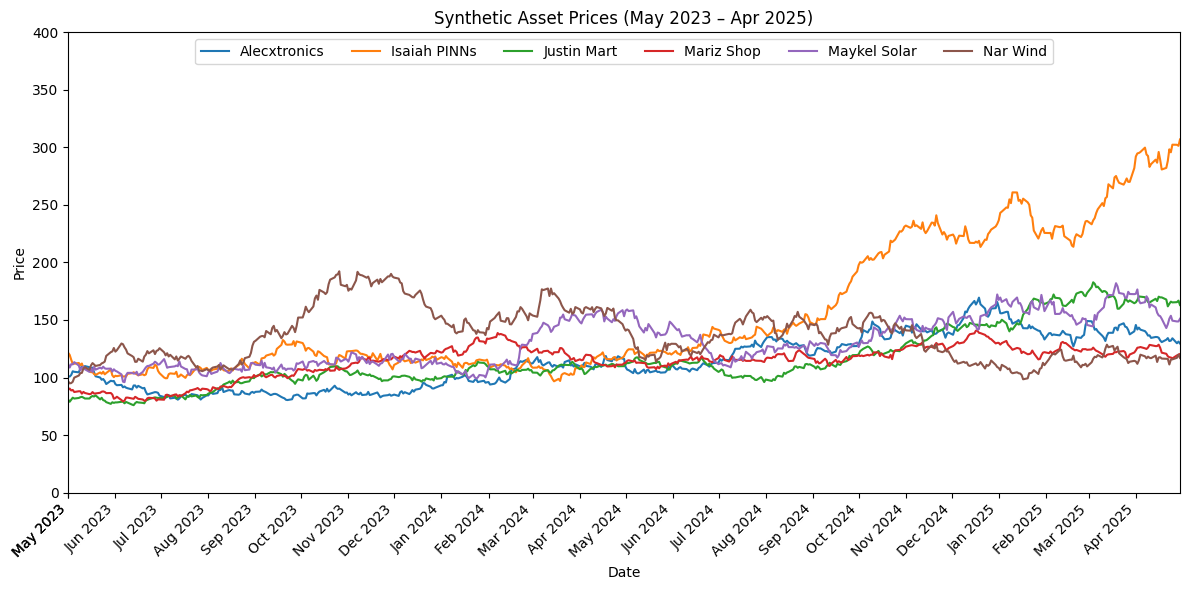

In [7]:
# --- Plot 1: Full-Period Asset Prices (May 2023 – Apr 2025) ---
fig, ax = plt.subplots(figsize=(12, 6))
for asset in price_data.columns:
    ax.plot(price_data.index, price_data[asset], label=asset)
ax.set_title("Synthetic Asset Prices (May 2023 – Apr 2025)")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_ylim(0, 400)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=6)
format_monthly_axis(ax, price_data.index.min(), price_data.index.max())
plt.tight_layout()
plt.show()


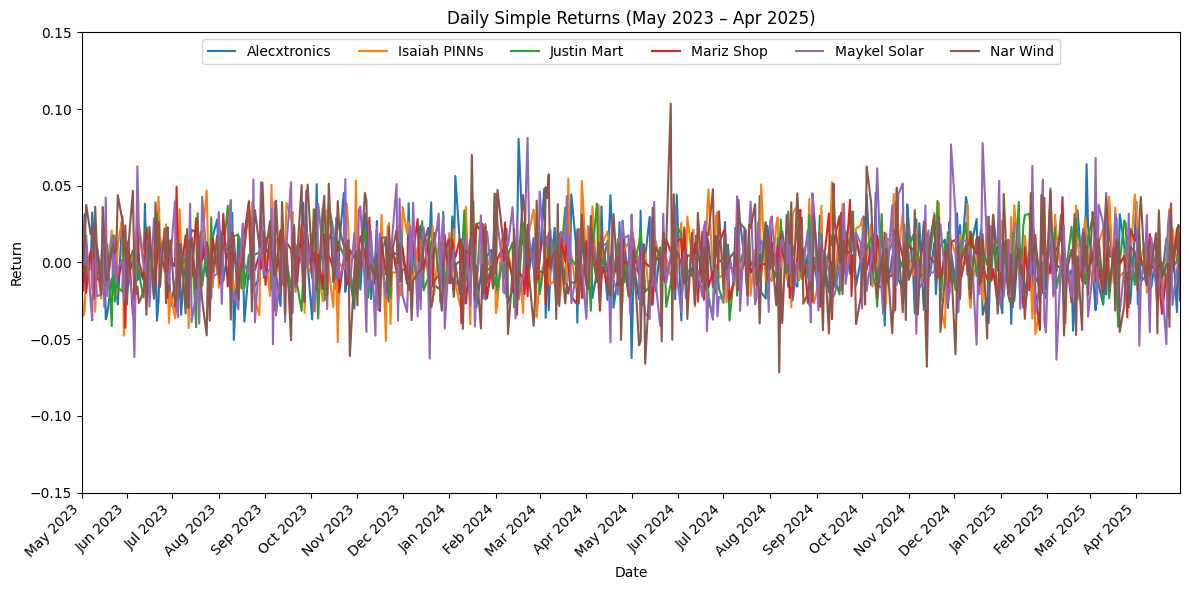

In [8]:
# --- Plot 2: Full-Period Daily Returns ---
returns = price_data.pct_change().dropna()
fig, ax = plt.subplots(figsize=(12, 6))
for asset in returns.columns:
    ax.plot(returns.index, returns[asset], label=asset)
ax.set_title("Daily Simple Returns (May 2023 – Apr 2025)")
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax.set_ylim(-0.15, 0.15)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=6)
format_monthly_axis(ax, returns.index.min(), returns.index.max())
plt.tight_layout()
plt.show()


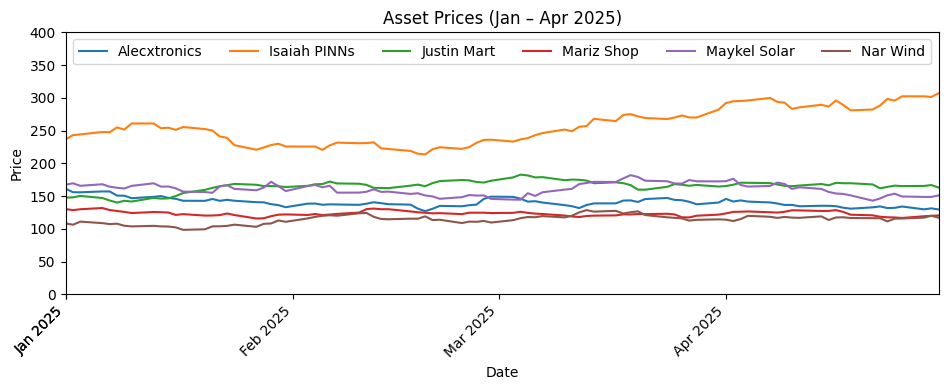

In [9]:
# --- Plot 3: Jan–Apr 2025 Asset Prices ---
period_prices = price_data.loc['2025-01-01':'2025-04-30']
fig, ax = plt.subplots(figsize=(10, 4))
for asset in period_prices.columns:
    ax.plot(period_prices.index, period_prices[asset], label=asset)
ax.set_title("Asset Prices (Jan – Apr 2025)")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_ylim(0, 400)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=6)
format_monthly_axis(ax, period_prices.index.min(), period_prices.index.max())
plt.tight_layout()
plt.show()


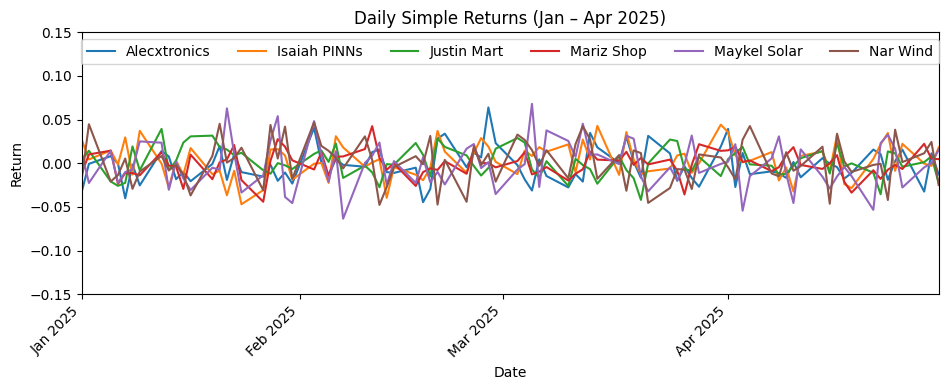

In [10]:
# --- Plot 4: Jan–Apr 2025 Daily Returns ---
period_returns = period_prices.pct_change().dropna()
fig, ax = plt.subplots(figsize=(10, 4))
for asset in period_returns.columns:
    ax.plot(period_returns.index, period_returns[asset], label=asset)
ax.set_title("Daily Simple Returns (Jan – Apr 2025)")
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax.set_ylim(-0.15, 0.15)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=6)
format_monthly_axis(ax, period_returns.index.min(), period_returns.index.max())
plt.tight_layout()
plt.show()


## **CVaR-Based QUBO Formulation**

In portfolio optimization, our goal is to maximize returns while minimizing downside risk. To achieve this, we used a risk measure called Conditional Value at Risk (CVaR), which captures the expected loss in the worst-case scenarios.

We formulated the problem as a Quadratic Unconstrained Binary Optimization (QUBO) task. This allows the use of quantum algorithms such as VQE to find the best asset allocation. The QUBO captures:

- **Objective**: Minimize CVaR while maximizing expected returns.
- **Constraints**:
  - Limit the number of assets selected (e.g., no more than 5 of 12).
  - Ensure assets come from diverse sectors (e.g., no more than 2 per sector).
  - Reduce turnover between rebalanced portfolios.

The result is a QUBO matrix encoding both financial goals and business rules, making it ready for quantum optimization.


**Asset Encoding and QUBO Parameters**

We define the asset encoding scheme, portfolio constraints, soft sector preferences, and QUBO hyperparameters. The model uses 6 assets with 2 bits each (to represent bundle count), plus selector qubits for asset inclusion. A total of 18 qubits are used.


In [11]:
# === ASSET ENCODING ===
asset_names = [
    'Alecxtronics', 'Isaiah PINNs',
    'Justin Mart', 'Mariz Shop',
    'Maykel Solar', 'Nar Wind'
]
num_assets = len(asset_names)                      # 6 assets
bits_per_asset = 2                                 # 2 bits per asset (0–3 bundles)
num_bundle_qubits = num_assets * bits_per_asset    # 12 qubits for bundles
num_selector_qubits = num_assets                   # 6 selector qubits (y_n)
num_qubits = num_bundle_qubits + num_selector_qubits  # 18 total qubits


In [12]:
# === PORTFOLIO CONSTRAINTS ===
K = 5                   # total bundles allowed per rebalancing
min_hold_days = 5       # minimum holding period (trading days)
lookback_window = 30    # number of past days used to compute Σ_t


In [13]:
# ===  QUBO PENALTY PARAMETERS ===
gamma_risk = 1.0        # risk-aversion weight
rho_budget = 20.0       # penalty for violating bundle budget
rho_or = 20.0           # enforce y_n = OR(x_{n,·})


In [14]:
# === SECTOR UTILITY (Soft Preference) ===
# Assign utility scores to assets:
#   - Technology (assets 0 & 1): 100
#   - Commerce   (assets 2 & 3): 25
#   - Energy     (assets 4 & 5): 50
util_scores = [100, 100, 25, 25, 50, 50]
lambda_util = 1.0        # utility reward weight


In [15]:
# === SOLVER & SAMPLER SETTINGS ===
ansatz_depth = 2         # depth of entangling RX–CZ blocks
num_reads = 1000         # number of VQE evaluations (shots)
alpha_cvar = 0.95        # CVaR confidence level


**Helper Functions: Portfolio Decoding & Visualization**

These functions assist in interpreting the bitstring solutions:
- `decode_sample` translates raw QUBO outputs into portfolio bundles, weights, and selections.
- `decode_and_print` prints the decoded results for the top solutions.
- `plot_top10_distribution` visualizes the probability of the top solutions across samples.


In [16]:
def decode_sample(bits, asset_names, bits_per_asset, K):
    """
    Decode a bitstring into a portfolio dictionary.

    Supports:
        - Variant 1: only bundle bits (length = N * B)
        - Variant 2: bundle bits + selector bits (length = N * B + N)

    Args:
        bits (list[int]): Binary bitstring from QUBO/VQE
        asset_names (list[str]): Asset identifiers
        bits_per_asset (int): Number of qubits per asset
        K (int): Total bundle limit (for weight normalization)

    Returns:
        dict: {
            'bundles':         {asset: bundle_count},
            'weights':         {asset: weight},
            'selector_flags':  {asset: selected_flag},
            'selected_assets': [list of selected asset names]
        }
    """
    N = len(asset_names)
    B = bits_per_asset
    total_bits = len(bits)

    # Decode bundle bits (supports B=2 or general case)
    bundles = [
        int(bits[B*n]) + 2*int(bits[B*n+1]) if B == 2
        else sum(int(bits[n*B + q]) * (2**q) for q in range(B))
        for n in range(N)
    ]

    # Decode selector bits if present
    if total_bits == N*B + N:
        selectors = [bool(int(bits[N*B + n])) for n in range(N)]
    else:
        # Default to: selected if bundles > 0
        selectors = [bundles[n] > 0 for n in range(N)]

    # Compute normalized weights
    weights = [bundles[n] / K for n in range(N)]

    # Collect selected assets
    selected = [asset_names[n] for n, flag in enumerate(selectors) if flag]

    return {
        'bundles': dict(zip(asset_names, bundles)),
        'weights': dict(zip(asset_names, weights)),
        'selector_flags': dict(zip(asset_names, selectors)),
        'selected_assets': selected
    }


In [17]:
def decode_and_print(samples, energies, asset_names, bits_per_asset, K, top_k=10):
    """
    Decode and print the top_k portfolios and their corresponding energies.

    Args:
        samples (np.ndarray): Binary samples (R × n_qubits)
        energies (np.ndarray): Energy values (R,)
        asset_names (list[str]): List of asset names
        bits_per_asset (int): Qubits per asset
        K (int): Total bundle capacity
        top_k (int): Number of top solutions to print
    """
    print("\nDecoded Top Portfolios:")
    for rank, (s, e) in enumerate(zip(samples[:top_k], energies[:top_k]), start=1):
        decoded = decode_sample(s.tolist(), asset_names, bits_per_asset, K)
        print(f"{rank:>2}. Energy = {e:.4f}")
        print("    Bundles        :", decoded['bundles'])
        print("    Weights        :", decoded['weights'])
        print("    Selector flags :", decoded['selector_flags'])
        print("    Selected assets:", decoded['selected_assets'])
        print()


In [18]:
def plot_top10_distribution(samples, energies, top_k=10):
    """
    Plot the frequency distribution of the top_k unique lowest-energy solutions.

    Args:
        samples (np.ndarray): Raw binary bitstrings (R × n_qubits)
        energies (np.ndarray): Corresponding energies (R,)
        top_k (int): Number of unique top solutions to include
    """
    # Step 1: Select top_k unique solutions with lowest energy
    sample_strs = [''.join(map(str, s.tolist())) for s in samples]
    best_per_sample = {}

    for s_str, s_vec, e in zip(sample_strs, samples, energies):
        if s_str not in best_per_sample or e < best_per_sample[s_str][1]:
            best_per_sample[s_str] = (s_vec, e)

    top_pairs = sorted(best_per_sample.values(), key=lambda p: p[1])[:top_k]
    top_strs = [''.join(map(str, p[0].tolist())) for p in top_pairs]

    # Step 2: Count frequency of top_k samples
    counts = {s: 0 for s in top_strs}
    for s in sample_strs:
        if s in counts:
            counts[s] += 1

    total = len(samples)
    probabilities = [counts[s] / total for s in top_strs]

    # Step 3: Plot
    fig, ax = plt.subplots()
    ax.bar(range(top_k), probabilities)
    ax.set_xticks(range(top_k))
    ax.set_xticklabels(top_strs, rotation=90, fontsize=6)
    ax.set_ylabel("Probability")
    ax.set_title(f"Probability Distribution of Top {top_k} Solutions")
    plt.tight_layout()
    plt.show()


**QUBO Construction**

This function builds the QUBO matrix for the quantum portfolio optimization problem. It balances risk, bundle budget, and soft sector utility preferences using selector variables and standard binary encoding for bundles.


In [26]:
def build_qubo(mu, Sigma, bits_per_asset, K,
               gamma, rho_budget, rho_or,
               util_scores=None,
               lambda_util=1.0):
    """
    Build QUBO matrix for portfolio optimization with:
      - Risk minimization
      - Soft budget constraint
      - OR-link between bundle bits and selectors
      - Optional sector utility rewards

    Args:
        mu (np.ndarray):        Expected returns, shape (N,)
        Sigma (np.ndarray):     Covariance matrix, shape (N, N)
        bits_per_asset (int):   Number of bits used per asset
        K (int):                Total number of allowed bundles
        gamma (float):          Weight on risk term
        rho_budget (float):     Penalty for (∑ bundles - K)²
        rho_or (float):         Penalty to enforce y_n = OR(x_{nq})
        util_scores (list):     Optional utility per asset (length N)
        lambda_util (float):    Weight on utility term

    Returns:
        Q (np.ndarray): QUBO matrix of shape (M, M), where M = N * B + N
    """
    N = len(mu)
    B = bits_per_asset
    M = N * B + N
    Q = np.zeros((M, M))
    w = np.array([2**q for q in range(B)])  # binary weights per asset

    # 1) Risk term: (γ / 2K²) xᵀ (Σ ⊗ wwᵀ) x
    fac = gamma / (2 * K**2)
    for n in range(N):
        for m in range(N):
            for q in range(B):
                for r in range(B):
                    i = n * B + q
                    j = m * B + r
                    Q[i, j] += fac * Sigma[n, m] * w[q] * w[r]

    # 2) Budget-quadratic penalty: ρ_budget (∑ w_q x_{nq} - K)²
    for i in range(N * B):
        ni, qi = divmod(i, B)
        for j in range(N * B):
            nj, qj = divmod(j, B)
            Q[i, j] += rho_budget * w[qi] * w[qj]

    # 3) Return and linear budget terms
    for n in range(N):
        for q in range(B):
            i = n * B + q
            Q[i, i] += -mu[n] * w[q] / K            # expected return
            Q[i, i] += -2 * rho_budget * K * w[q]   # linear budget term

    # 4) OR-link penalty: enforce y_n = OR(x_{nq})
    for n in range(N):
        y = N * B + n  # index of y_n
        for q in range(B):
            x = n * B + q
            Q[x, x] += rho_or
            Q[y, y] += rho_or
            Q[x, y] += -2 * rho_or

    # 5) Utility reward: −λ * U_n * y_n
    if util_scores is None:
        util_scores = [0.0] * N

    for n in range(N):
        y = N * B + n
        Q[y, y] += -lambda_util * util_scores[n]

    return Q


## **Quantum Circuit & VQE Implementation**

Once we had our QUBO ready, we needed a way to solve it using quantum tools. We used Variational Quantum Eigensolver (VQE), a hybrid quantum-classical algorithm that simulates how quantum circuits can search for optimal solutions.

VQE works by tuning the parameters of a quantum circuit to find the lowest possible "energy" state—analogous here to the minimum risk portfolio. In this context, each qubit represents whether an asset is included in the portfolio (1) or not (0).

We used the Cirq library to define and simulate the quantum circuit. Although this project ran on a classical computer, it mimics the behavior of real quantum systems and is a step toward implementing quantum finance models on future hardware.


In [27]:
# === 1) QUBO → Pauli-Z Hamiltonian ===
def qubo_to_pauli_hamiltonian(Q, qubits):
    """
    Convert QUBO matrix Q into equivalent Pauli-Z Hamiltonian.
    x = (1 - Z)/2 → x_i x_j = 1/4 (1 - Z_i - Z_j + Z_i Z_j)
    """
    n = len(qubits)
    ops = []
    const = 0.0

    for i in range(n):
        qi = Q[i, i]
        const += qi * 0.5
        ops.append(-0.5 * qi * cirq.Z(qubits[i]))
        for j in range(i + 1, n):
            qij = Q[i, j]
            coeff = qij / 4.0
            const += coeff
            ops.append(coeff * cirq.Z(qubits[i]) * cirq.Z(qubits[j]))
            ops.append(-coeff * cirq.Z(qubits[i]))
            ops.append(-coeff * cirq.Z(qubits[j]))
    return sum(ops) + const


# === 2) RX–CZ hardware-efficient ansatz ===
def make_ansatz(qubits, depth):
    """
    Build a hardware-efficient variational ansatz using RX + CZ layers.
    """
    circuit = cirq.Circuit()
    params = []

    # Initial RX layer
    for i, q in enumerate(qubits):
        θ = sympy.Symbol(f"θ_0_{i}")
        params.append(θ)
        circuit.append(cirq.rx(θ)(q))

    # Repeat [CZ → RX] layers
    for layer in range(1, depth + 1):
        for i in range(len(qubits) - 1):
            circuit.append(cirq.CZ(qubits[i], qubits[i + 1]))
        for i, q in enumerate(qubits):
            θ = sympy.Symbol(f"θ_{layer}_{i}")
            params.append(θ)
            circuit.append(cirq.rx(θ)(q))

    return circuit, params


# === 3) CVaR cost function ===
def vqe_cvar_cost(params, simulator, circuit, params_syms, Q, num_reads, alpha):
    """
    Evaluate CVaR loss from circuit samples using QUBO matrix Q.
    """
    bound = cirq.resolve_parameters(circuit, dict(zip(params_syms, params)))
    result = simulator.run(bound, repetitions=num_reads)
    samples = result.measurements['m']  # shape: (num_reads, n_qubits)

    # Energy = xᵀ Q x
    energies = np.einsum('bi,ij,bj->b', samples, Q, samples)

    # CVaR: mean of lowest α-fraction energies
    k = max(1, int(alpha * len(energies)))
    return np.mean(np.sort(energies)[:k])


# === 4) Main VQE-CVaR optimizer ===
def run_vqe_cvar(Q, depth=2, num_reads=500, alpha=0.5):
    """
    Run VQE optimization with CVaR loss to minimize xᵀ Q x.
    """
    n_qubits = Q.shape[0]
    qubits = cirq.LineQubit.range(n_qubits)

    # Build circuit
    _ = qubo_to_pauli_hamiltonian(Q, qubits)  # not used in sampling
    circuit, params_syms = make_ansatz(qubits, depth)
    circuit.append(cirq.measure(*qubits, key='m'))

    # Optimization
    simulator = cirq.Simulator()
    x0 = np.random.uniform(0, 2 * np.pi, size=len(params_syms))
    res = minimize(
        vqe_cvar_cost, x0,
        args=(simulator, circuit, params_syms, Q, num_reads, alpha),
        method='COBYLA',
        options={'maxiter': 100, 'tol': 1e-3}
    )

    # Final sampling from optimal parameters
    bound_final = cirq.resolve_parameters(circuit, dict(zip(params_syms, res.x)))
    final_res = simulator.run(bound_final, repetitions=num_reads)
    samples = final_res.measurements['m']  # shape: (num_reads, n_qubits)
    energies = np.einsum('bi,ij,bj->b', samples, Q, samples)
    order = np.argsort(energies)

    return samples[order], energies[order]


In [28]:
# === Build & visualize ansatz ===

# Define qubits (must match size of QUBO)
qubits = cirq.LineQubit.range(num_qubits)

# Build RX–CZ ansatz circuit
ansatz_depth = 2
circuit, params = make_ansatz(qubits, ansatz_depth)

# Print ASCII diagram
print(f"=== Ansatz ({num_qubits} qubits, depth={ansatz_depth}) ===")
print(circuit)

# Optional: Export SVG for paper/report
svg = SVGCircuit(circuit)._repr_svg_()
outpath = "/content/drive/MyDrive/Colab Notebooks/Quantum Project/ansatz.svg"
with open(outpath, "w") as f:
    f.write(svg)
print(f"SVG saved to: {outpath}")


=== Ansatz (18 qubits, depth=2) ===
0: ────Rx(θ_0_0)────@───Rx(θ_1_0)───────────────@───────────Rx(θ_2_0)─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                    │                           │
1: ────Rx(θ_0_1)────@───@───────────Rx(θ_1_1)───@───────────@───────────Rx(θ_2_1)─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                        │                                   │
2: ────Rx(θ_0_2)────────@───────────@───────────Rx(θ_1_2)───@───────────@───────────Rx(θ_2_2)─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                           

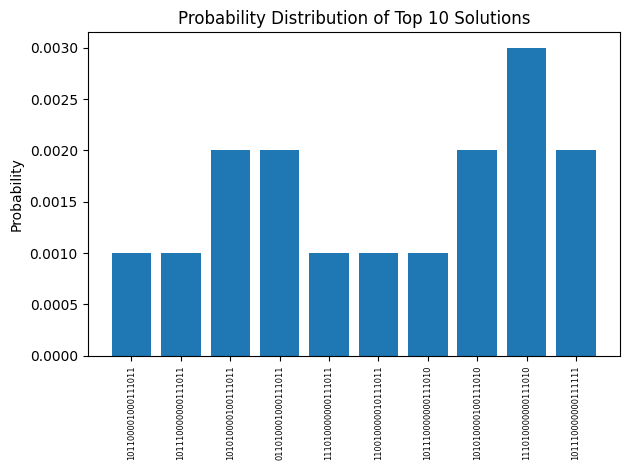


Decoded Top Portfolios:
 1. Energy = -705.0122
    Bundles        : {'Alecxtronics': 1, 'Isaiah PINNs': 3, 'Justin Mart': 0, 'Mariz Shop': 0, 'Maykel Solar': 1, 'Nar Wind': 0}
    Weights        : {'Alecxtronics': 0.2, 'Isaiah PINNs': 0.6, 'Justin Mart': 0.0, 'Mariz Shop': 0.0, 'Maykel Solar': 0.2, 'Nar Wind': 0.0}
    Selector flags : {'Alecxtronics': True, 'Isaiah PINNs': True, 'Justin Mart': True, 'Mariz Shop': False, 'Maykel Solar': True, 'Nar Wind': True}
    Selected assets: ['Alecxtronics', 'Isaiah PINNs', 'Justin Mart', 'Maykel Solar', 'Nar Wind']

 2. Energy = -705.0105
    Bundles        : {'Alecxtronics': 1, 'Isaiah PINNs': 3, 'Justin Mart': 1, 'Mariz Shop': 0, 'Maykel Solar': 0, 'Nar Wind': 0}
    Weights        : {'Alecxtronics': 0.2, 'Isaiah PINNs': 0.6, 'Justin Mart': 0.2, 'Mariz Shop': 0.0, 'Maykel Solar': 0.0, 'Nar Wind': 0.0}
    Selector flags : {'Alecxtronics': True, 'Isaiah PINNs': True, 'Justin Mart': True, 'Mariz Shop': False, 'Maykel Solar': True, 'Nar Wind': T

In [29]:
# === Sanity Check: Run QUBO → VQE-CVaR on First Trading Day ===

# Select first trading day
first_day = period_returns.index.min()

# Extract expected returns and covariance
mu_t    = period_returns.loc[first_day].values           # shape: (N,)
Sigma_t = Sigma_by_day[first_day].values                 # shape: (N, N)

# Build QUBO matrix
Q = build_qubo(
    mu=mu_t,
    Sigma=Sigma_t,
    bits_per_asset=bits_per_asset,
    K=K,
    gamma=gamma_risk,
    rho_budget=rho_budget,
    rho_or=rho_or,
    util_scores=util_scores,
    lambda_util=lambda_util
)

# Run VQE-CVaR solver
samples, energies = run_vqe_cvar(
    Q,
    depth=ansatz_depth,
    num_reads=num_reads,
    alpha=alpha_cvar
)

# Plot top-10 sample distribution
plot_top10_distribution(samples, energies, top_k=10)

# Deduplicate samples (keep lowest energy)
sample_strs     = [''.join(map(str, s)) for s in samples]
best_per_sample = {}
for s_str, s, en in zip(sample_strs, samples, energies):
    if s_str not in best_per_sample or en < best_per_sample[s_str][1]:
        best_per_sample[s_str] = (s, en)

# Sort unique samples by energy
unique_pairs    = sorted(best_per_sample.values(), key=lambda p: p[1])
unique_samples  = np.array([p[0] for p in unique_pairs])
unique_energies = np.array([p[1] for p in unique_pairs])

# Decode and print top-10 portfolios
decode_and_print(
    unique_samples,
    unique_energies,
    asset_names,
    bits_per_asset,
    K,
    top_k=10
)


### **Post-Processing and Practical Constraints**

After solving daily QUBOs using the quantum variational algorithm, we performed trajectory-level post-processing to simulate realistic portfolio management conditions.

- **Sharpe-Based Filtering**: For each trading day, top portfolio candidates were selected based on their Sharpe ratios, promoting strong return-to-risk profiles.

- **Minimum Holding Period**: To prevent excessive turnover, we enforced a minimum holding period. Assets already held in the portfolio were only allowed to be dropped if they had been held for a fixed number of trading days (e.g., 5 days). This ensured rebalancing discipline and aligned with realistic investment constraints.

- **Trajectory Selection**: At each time step, the strategy either maintained the current portfolio (a “hold” action) or transitioned to a new candidate, subject to all holding constraints.

This post-processing ensures that the final investment trajectory is both quantum-optimized and grounded in practical trading rules often followed by institutional investors.


In [30]:
def full_vqe_sharpe_strategy(returns_df, Sigma_dict, asset_names,
                             bits_per_asset, K,
                             gamma_risk, rho_budget,
                             rho_or,
                             util_scores, lambda_util,
                             ansatz_depth, num_reads, alpha_cvar,
                             min_hold_days, top_N,
                             date_list, output_csv_path):
    """
    Runs VQE-CVaR using the soft-sector-utility QUBO variant each day,
    post-selects a multi-day trajectory under holding constraints, and saves a CSV of weights.

    Args:
      returns_df:     DataFrame of returns indexed by trading dates
      Sigma_dict:     dict date → covariance DataFrame
      asset_names:    list of strings
      bits_per_asset: int
      K:              total bundles
      gamma_risk:     float risk aversion
      rho_budget:     float budget penalty
      rho_or:         float OR-link penalty
      util_scores:    list of soft-sector utilities per asset
      lambda_util:    float, weight on utility term
      ansatz_depth:   int, circuit depth for VQE
      num_reads:      int, number of measurement shots
      alpha_cvar:     float, CVaR alpha
      min_hold_days:  int, minimum holding period constraint
      top_N:          int, top candidate trajectories to keep
      date_list:      list of trading dates to process
      output_csv_path:str, path to output weights CSV
    """
    valid_dates = list(returns_df.index.intersection(date_list))
    if len(valid_dates) < len(date_list):
        missing = sorted(set(date_list) - set(valid_dates))
        print(f"Skipping {len(missing)} non-trading days: {missing}")
    date_list = valid_dates
    T = len(date_list)

    def is_valid(dec):
        return abs(sum(dec['weights'].values()) - 1.0) <= 1e-6

    daily_candidates = []
    for t in tqdm(range(T), desc="Solving days", unit="day"):
        date    = date_list[t]
        mu_t    = returns_df.loc[date].values
        Sigma_t = Sigma_dict[date].values

        Q = build_qubo(
            mu=mu_t,
            Sigma=Sigma_t,
            bits_per_asset=bits_per_asset,
            K=K,
            gamma=gamma_risk,
            rho_budget=rho_budget,
            rho_or=rho_or,
            util_scores=util_scores,
            lambda_util=lambda_util
        )

        samples, energies = run_vqe_cvar(
            Q,
            depth=ansatz_depth,
            num_reads=num_reads,
            alpha=alpha_cvar
        )

        seen = {}
        for s, e in zip(samples, energies):
            key = ''.join(map(str, s))
            if key not in seen or e < seen[key][1]:
                seen[key] = (s, e)

        valid_pairs = []
        for bits, e in sorted(seen.values(), key=lambda p: p[1]):
            dec = decode_sample(bits, asset_names, bits_per_asset, K)
            if is_valid(dec):
                valid_pairs.append((bits, e))
            if len(valid_pairs) >= top_N:
                break
        if len(valid_pairs) < top_N:
            valid_pairs = sorted(seen.values(), key=lambda p: p[1])[:top_N]

        cands = []
        for bits, e in valid_pairs:
            dec    = decode_sample(bits, asset_names, bits_per_asset, K)
            w_vec  = np.array([dec['weights'][a] for a in asset_names])
            ret    = mu_t.dot(w_vec)
            vol    = np.sqrt(w_vec @ Sigma_t @ w_vec) if w_vec.any() else 0.0
            sharpe = ret / vol if vol > 0 else 0.0
            cands.append({
                'bits':    bits,
                'energy':  e,
                'weights': dec['weights'],
                'flags':   dec['selector_flags'],
                'sharpe':  sharpe
            })
        daily_candidates.append({'date': date, 'cands': cands})

    branches = []
    for cand in daily_candidates[0]['cands']:
        pdays    = {n: 0 for n, f in enumerate(cand['flags'].values()) if f}
        pweights = {n: cand['weights'][asset_names[n]] for n in pdays}
        branches.append({
            'traj_bits':      [cand['bits']],
            'traj_sharpes':   [cand['sharpe']],
            'traj_weights':   [cand['weights']],
            'purchase_days':  pdays,
            'purchase_weights': pweights
        })

    for t in tqdm(range(1, T), desc="Post-selecting", unit="day"):
        date    = date_list[t]
        mu_t    = returns_df.loc[date].values
        Sigma_t = Sigma_dict[date].values
        new_br  = []

        for b in branches:
            hold_bits = b['traj_bits'][-1]
            dec_h     = decode_sample(hold_bits, asset_names, bits_per_asset, K)
            w_h       = np.array([dec_h['weights'][a] for a in asset_names])
            ret_h     = mu_t.dot(w_h)
            vol_h     = np.sqrt(w_h @ Sigma_t @ w_h) if w_h.any() else 0.0
            sharpe_h  = ret_h / vol_h if vol_h > 0 else 0.0
            hold_cand = {
                'bits':    hold_bits,
                'energy':  None,
                'weights': dec_h['weights'],
                'flags':   dec_h['selector_flags'],
                'sharpe':  sharpe_h
            }

            todays = daily_candidates[t]['cands'] + [hold_cand]
            for cand in todays:
                valid = True
                for n, d in b['purchase_days'].items():
                    if t - d < min_hold_days:
                        name = asset_names[n]
                        if not cand['flags'][name] or cand['weights'][name] < b['purchase_weights'][n]:
                            valid = False
                            break
                if not valid:
                    continue

                new_pdays    = b['purchase_days'].copy()
                new_pweights = b['purchase_weights'].copy()
                for n, a in enumerate(asset_names):
                    if cand['flags'][a] and n not in new_pdays:
                        new_pdays[n]    = t
                        new_pweights[n] = cand['weights'][a]
                new_br.append({
                    'traj_bits':      b['traj_bits'] + [cand['bits']],
                    'traj_sharpes':   b['traj_sharpes'] + [cand['sharpe']],
                    'traj_weights':   b['traj_weights'] + [cand['weights']],
                    'purchase_days':  new_pdays,
                    'purchase_weights': new_pweights
                })

        new_br.sort(key=lambda b: b['traj_sharpes'][-1], reverse=True)
        branches = new_br[:top_N]

    if branches:
        best = branches[0]
        df = pd.DataFrame(best['traj_weights'],
                          index=date_list,
                          columns=asset_names).T
        df.index.name   = 'Asset'
        df.columns.name = 'Date'
        df.loc['Total'] = df.sum(axis=0)
        df.to_csv(output_csv_path)
        print(f"Saved best trajectory weights to {output_csv_path}")
    else:
        print("No valid trajectory; CSV not saved.")

    return branches


In [32]:
# ✅ Sanity Check: Full Trajectory Strategy (Soft-Sector Utility Only)

branches = full_vqe_sharpe_strategy(
    returns_df      = period_returns,
    Sigma_dict      = Sigma_by_day,
    asset_names     = asset_names,
    bits_per_asset  = bits_per_asset,
    K               = K,
    gamma_risk      = gamma_risk,
    rho_budget      = rho_budget,
    rho_or          = rho_or,
    util_scores     = util_scores,
    lambda_util     = lambda_util,
    ansatz_depth    = ansatz_depth,
    num_reads       = num_reads,
    alpha_cvar      = alpha_cvar,
    min_hold_days   = min_hold_days,
    top_N           = 10,
    date_list       = period_days,
    output_csv_path = "/content/drive/MyDrive/Colab Notebooks/Quantum Project/strategy_weights_soft_sector.csv"
)


Skipping 1 non-trading days: [Timestamp('2025-01-01 00:00:00')]


Solving days:   0%|          | 0/85 [00:00<?, ?day/s]

Post-selecting:   0%|          | 0/84 [00:00<?, ?day/s]

Saved best trajectory weights to /content/drive/MyDrive/Colab Notebooks/Quantum Project/strategy_weights_soft_sector.csv


## **Results & Visualization**

The optimized portfolios were compared to randomly generated portfolios to assess performance. We visualized:

- The **efficient frontier** showing the trade-off between return and risk.
- The **distribution of portfolio weights** across sectors.
- **Risk vs. return scatter plots**, highlighting which portfolios performed best.

Results showed that the quantum-optimized portfolios generally outperformed random ones in terms of balancing CVaR and expected return, while still satisfying sector and turnover constraints.


In [33]:
# Define project directory and output CSV paths
PROJECT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/Quantum Project")
PROJECT_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_CSV = PROJECT_DIR / "random_perf.csv"  # Random portfolio results
QUBO_CSV   = PROJECT_DIR / "qubo_perf.csv"    # QUBO-based strategy results


In [35]:
# Get all business days in the target window
all_days = pd.date_range('2025-01-01', '2025-04-30', freq='B')

# Match with available return data
valid_days = list(period_returns.index.intersection(all_days))

# Summary of the evaluation window
print(f"Evaluating over {len(valid_days)} trading days "
      f"from {valid_days[0].date()} to {valid_days[-1].date()}")


Evaluating over 85 trading days from 2025-01-02 to 2025-04-30


In [36]:
# Computes realized volatility and profit for a full trading trajectory
def eval_period(traj_weights, dates, returns_df, asset_names):
    r_ts = np.array([
        returns_df.loc[day].dot(
            np.array([traj_weights[i][name] for name in asset_names])
        )
        for i, day in enumerate(dates)
    ])
    return np.std(r_ts, ddof=1), np.prod(1 + r_ts) - 1


In [37]:
# Sample N-asset random portfolios with integer weight budget K
def sample_random_portfolios(N, K, dates, n_samples=200):
    trajectories = []
    for _ in range(n_samples):
        counts = np.random.multinomial(K, [1/N]*N)
        w = {asset_names[i]: counts[i]/K for i in range(N)}
        trajectories.append([w.copy() for _ in dates])  # Static strategy
    return trajectories

# Generate and evaluate random strategies
rand_trajs = sample_random_portfolios(num_assets, K, valid_days, n_samples=200)
rand_perf  = [eval_period(traj, valid_days, period_returns, asset_names)
              for traj in rand_trajs]
rand_vol, rand_profit = zip(*rand_perf)

# Save to CSV
pd.DataFrame({'volatility': rand_vol, 'profit': rand_profit}) \
  .to_csv(RANDOM_CSV, index=False)
print(f"Random performance saved to {RANDOM_CSV}")


Random performance saved to /content/drive/MyDrive/Colab Notebooks/Quantum Project/random_perf.csv


In [39]:
# Define risk-aversion (γ) levels to sweep
risk_levels = [0.05, 0.10, 0.15, 0.20, 0.40, 0.60, 0.80, 1.00]
qubo_records = []

# Show progress bar
pbar = tqdm(risk_levels,
            desc="Risk sweep",
            unit="γ",
            leave=True,
            dynamic_ncols=True)

# Run strategy for each γ
for γ in pbar:
    strat_csv = PROJECT_DIR / f"{int(100*γ)}_strategy_weights.csv"

    if strat_csv.exists():
        # Load saved strategy
        df = pd.read_csv(strat_csv, index_col="Asset")
        traj_weights = df.drop("Total").T.to_dict(orient="records")
        vol, profit = eval_period(traj_weights, valid_days,
                                  period_returns, asset_names)
    else:
        # Run full QUBO solver
        branches = full_vqe_sharpe_strategy(
            returns_df      = period_returns,
            Sigma_dict      = Sigma_by_day,
            asset_names     = asset_names,
            bits_per_asset  = bits_per_asset,
            K               = K,
            gamma_risk      = γ,
            rho_budget      = rho_budget,
            rho_or          = rho_or,
            util_scores     = util_scores,
            lambda_util     = lambda_util,
            ansatz_depth    = ansatz_depth,
            num_reads       = num_reads,
            alpha_cvar      = alpha_cvar,
            min_hold_days   = min_hold_days,
            top_N           = 10,
            date_list       = valid_days,
            output_csv_path = strat_csv
        )

        # Evaluate best trajectory (if any)
        if not branches:
            vol, profit = np.nan, np.nan
        else:
            best = branches[0]
            vol, profit = eval_period(best['traj_weights'],
                                      valid_days, period_returns, asset_names)

    # Log results
    qubo_records.append({
        'risk_level': γ,
        'volatility': vol,
        'profit': profit
    })

    # Update tqdm live display
    pbar.set_postfix({
        'vol': f"{vol:.4f}",
        'profit': f"{profit:.4f}"
    })

# Save all QUBO results
pd.DataFrame(qubo_records).to_csv(QUBO_CSV, index=False)
print(f"QUBO performance saved to {QUBO_CSV}")

Risk sweep:   0%|          | 0/8 [00:00<?, ?γ/s]

QUBO performance saved to /content/drive/MyDrive/Colab Notebooks/Quantum Project/qubo_perf.csv


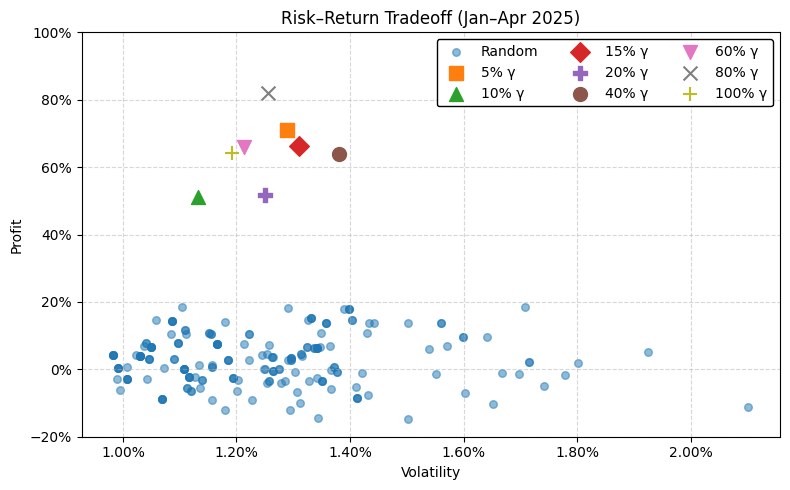

In [40]:
# Load both performance CSVs
if RANDOM_CSV.exists() and QUBO_CSV.exists():
    rand_df = pd.read_csv(RANDOM_CSV)
    qubo_df = pd.read_csv(QUBO_CSV)

    fig, ax = plt.subplots(figsize=(8, 5))

    # Plot: random portfolios (scatter cloud)
    ax.scatter(
        rand_df['volatility'], rand_df['profit'],
        s=30, alpha=0.5, label="Random", marker='o'
    )

    # Plot: QUBO strategies per γ (distinct markers)
    markers = ['s', '^', 'D', 'P', 'o', 'v', 'x', '+']
    for (idx, row), m in zip(qubo_df.iterrows(), markers):
        ax.scatter(
            row['volatility'], row['profit'],
            s=100, label=f"{int(100*row['risk_level'])}% γ", marker=m
        )

    # Axis labels and formatting
    ax.set_xlabel("Volatility")
    ax.set_ylabel("Profit")
    ax.set_title("Risk–Return Tradeoff (Jan–Apr 2025)")

    # Percent format for both axes
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    # Y-axis range: from -20% to 100%
    ax.set_ylim(-0.20, 1.00)

    # Gridlines for clarity
    ax.grid(True, linestyle='--', alpha=0.5)

    # Legend configuration
    ax.legend(
        loc='upper right',
        ncol=3,
        frameon=True,
        facecolor='white',
        framealpha=1,
        edgecolor='black'
    )

    plt.tight_layout()
    plt.show()

else:
    # Handle missing CSVs
    missing = [p.name for p in (RANDOM_CSV, QUBO_CSV) if not p.exists()]
    print(f"Cannot plot: missing files: {missing}")

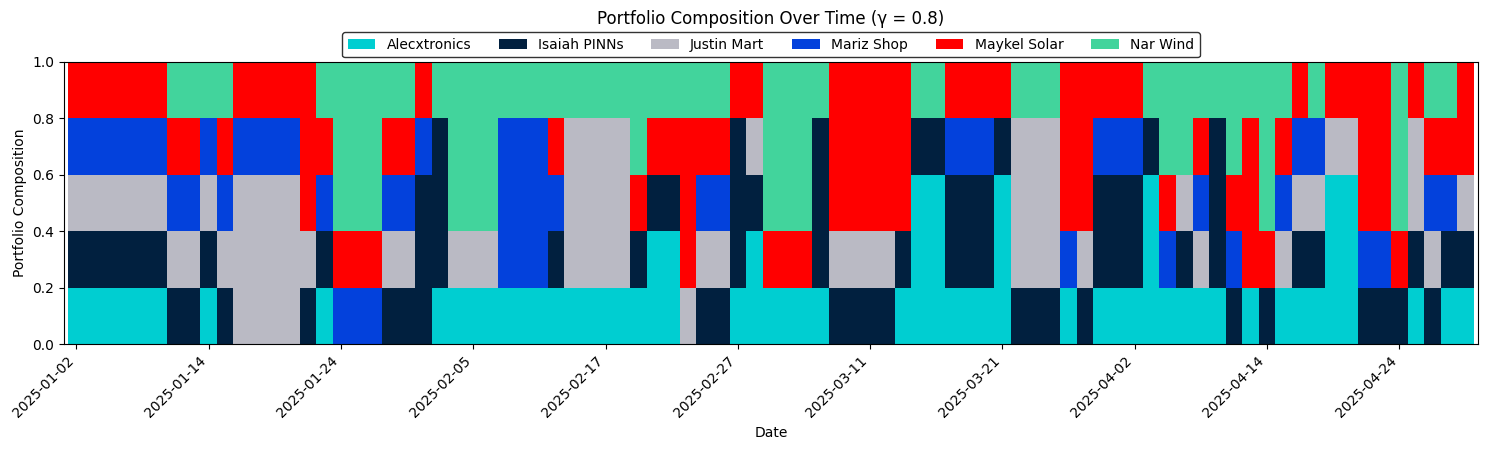

In [41]:
# Load weights from saved strategy CSV
PROJECT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/Quantum Project")
df = pd.read_csv(PROJECT_DIR / "80_strategy_weights.csv", index_col="Asset")

# Drop total row (if present) and transpose: rows = dates, columns = assets
df = df.drop(index=["Total"], errors="ignore").T
df.index = pd.to_datetime(df.index)

# Filter to only include days starting from Jan 2, 2025
df = df[df.index >= pd.Timestamp("2025-01-02")]

# Custom color palette (trimmed to number of assets)
my_colors = [
    "#00ced1", "#01203f", "#babac4",
    "#0341dc", "#ff0000", "#42d49c"
][:df.shape[1]]

# Plot: stacked bar chart of portfolio composition over time
fig, ax = plt.subplots(figsize=(15, 5))
df.plot(
    kind="bar",
    stacked=True,
    width=1.0,
    color=my_colors,
    ax=ax,
    legend=False
)

# Axis labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Portfolio Composition")
ax.set_ylim(0, 1)
ax.set_title("Portfolio Composition Over Time (γ = 0.8)", pad=27)

# Thin out x-tick labels (roughly one every 10 bars)
step = max(1, len(df) // 10)
ax.set_xticks(ax.get_xticks()[::step])
ax.set_xticklabels(
    [d.strftime("%Y-%m-%d") for d in df.index[::step]],
    rotation=45,
    ha="right"
)

# Show legend at top with 6 columns
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, 0.99),
    ncol=6,
    frameon=True,
    facecolor='white',
    edgecolor='black'
)

# Adjust layout to fit legend and title
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

## **Insights & Reflection**

### **What Worked Well**
- CVaR provided a meaningful risk metric, capturing worst-case scenarios.
- The VQE framework successfully optimized the QUBO under realistic constraints.
- Post-selection ensured outputs remained interpretable and policy-compliant.

### **Areas for Improvement**
- The model could benefit from using **real financial data** to assess robustness.
- Incorporating **transaction costs** would make turnover constraints more realistic.
- Larger portfolios with more assets and historical depth could challenge scalability.

### **Future Directions**
- Run the same models on actual quantum processors (e.g., IBM Q or Rigetti).
- Add new constraints such as minimum allocation or leverage.
- Explore multi-objective optimization (risk-return-liquidity).


## **References**

[1] Cirq Developers, https://quantumai.google/cirq

[2] H. Markowitz, “Portfolio selection,” The Journal of Finance, vol. 7, no. 1, p. 77, Mar. 1952. doi:10.2307/2975974

[3] W. F. Sharpe, “Capital asset prices: A theory of market equilibrium under conditions of risk,” The Journal of Finance, vol. 19, no. 3, pp. 425–442, Sep. 1964. doi:10.1111/j.1540-6261.1964.tb02865.x

[4] G. Buonaiuto, F. Gargiulo, G. De Pietro, M. Esposito, and M. Pota, “Best practices for portfolio optimization by Quantum Computing, experimented on real quantum devices,” Scientific Reports, vol. 13, no. 1, Nov. 2023. doi:10.1038/s41598-023-45392-w

[5] R. T. Rockafellar and S. Uryasev, “Optimization of conditional value-at-risk,” The Journal of Risk, vol. 2, no. 3, pp. 21–41, 2000. doi:10.21314/jor.2000.038

[6] S. Mugel et al., “Hybrid quantum investment optimization with minimal holding period,” Scientific Reports, vol. 11, no. 1, Oct. 2021. doi:10.1038/s41598-021-98297-x-
